# preprocessing of all GB files

In [21]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import eccodes
import subprocess
import pandas as pd
import csv
import matplotlib.pyplot as plt
import logging
import cfgrib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import re
from pathlib import Path
from utils.parameter_mapping import ParameterMapper


In [2]:
# # 设置环境变量
# eccodes_definition_path = r"D:\softwares\Anaconda\envs\myenv_new\Library\share\eccodes\definitions"
# os.environ['ECCODES_DEFINITION_PATH'] = eccodes_definition_path

## list all the variables

In [2]:
def list_grib_variables(grib_path):
    """
    列出 GRIB 文件中所有的变量及其详细信息。
    
    参数：
    - grib_path (str): GRIB 文件的路径
    
    返回：
    - pandas.DataFrame: 包含变量信息的表格
    """
    variables = []
    
    # 检查文件是否存在
    if not os.path.exists(grib_path):
        raise FileNotFoundError(f"GRIB 文件未找到: {grib_path}")
    
    with open(grib_path, 'rb') as f:
        while True:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break  # 文件结束
            
            try:
                var_code = eccodes.codes_get(gid, 'indicatorOfParameter')
                var_abbr = eccodes.codes_get(gid, 'shortName')
                var_desc = eccodes.codes_get(gid, 'name')
                var_units = eccodes.codes_get(gid, 'units')
                level_type = eccodes.codes_get(gid, 'indicatorOfTypeOfLevel')
                level = eccodes.codes_get(gid, 'level')
                tri = eccodes.codes_get(gid, 'timeRangeIndicator')
                
                
                variables.append({
                    'Code': var_code,
                    'Short_name': var_abbr,
                    'Description': var_desc,
                    'Units': var_units,
                    'Leveltype': level_type,
                    'Level': level,
                    'TRI': tri,
                })
            except Exception as e:
                print(f"Error processing message: {e}")
            finally:
                eccodes.codes_release(gid)
    
    # 转换为 Pandas DataFrame
    df = pd.DataFrame(variables)
    
    # 去除重复项（因为同一变量可能在不同层级或 TRI 下出现）
    df_unique = df.drop_duplicates()
    
    return df_unique

In [ ]:
grib_first_path = "HARMONIE_AROME_meteo_24hrs/mbr000/fc2024070912+001GB_UWCW01_N20e"

variables_df = list_grib_variables(grib_first_path)
variables_df

In [5]:
import eccodes
import pandas as pd
import os

# 定义 HARMONIE 参数映射表
HARMONIE_PARAMS = {
    1: {'shortName': ['PMSL', 'PSRF'], 'name': ['Pressure altitude above MSL', 'Pressure height above ground'], 'units': 'Pa'},
    6: {'shortName': 'GEOP', 'name': 'Geopotential', 'units': 'm²/s²'},
    11: {'shortName': 'TMP', 'name': 'Temperature', 'units': 'K'},
    17: {'shortName': '2TD', 'name': 'Dew-point temperature 2m', 'units': 'K'},
    20: {'shortName': 'VIS', 'name': 'Visibility', 'units': 'm'},
    33: {'shortName': 'UGRD', 'name': 'U-component of wind', 'units': 'm/s'},
    34: {'shortName': 'VGRD', 'name': 'V-component of wind', 'units': 'm/s'},
    40: {'shortName': 'VVEL', 'name': 'Vertical velocity', 'units': 'm/s'},
    41: {'shortName': 'ABSV', 'name': 'Absolute vorticity', 'units': 's⁻¹'},
    52: {'shortName': 'RH', 'name': 'Relative humidity', 'units': '%'},
    65: {'shortName': 'WEASD', 'name': 'Water equivalent of snow', 'units': 'kg/m²'},
    71: {'shortName': 'TCC', 'name': 'Total cloud cover', 'units': '%'},
    73: {'shortName': 'LCC', 'name': 'Low cloud cover', 'units': '%'},
    74: {'shortName': 'MCC', 'name': 'Medium cloud cover', 'units': '%'},
    75: {'shortName': 'HCC', 'name': 'High cloud cover', 'units': '%'},
    115: {'shortName': 'SWR', 'name': 'Net shortwave radiation', 'units': 'J/m²'},
    116: {'shortName': 'LWR', 'name': 'Net longwave radiation', 'units': 'J/m²'},
    117: {'shortName': 'GRAD', 'name': 'Global radiation flux', 'units': 'W/m²'},
    121: {'shortName': 'MX2T', 'name': 'Maximum temperature 2m', 'units': 'K'},
    122: {'shortName': 'MN2T', 'name': 'Minimum temperature 2m', 'units': 'K'},
    160: {'shortName': 'CAPE', 'name': 'Convective available potential energy', 'units': 'J/kg'},
    161: {'shortName': 'CIN', 'name': 'Convective inhibition', 'units': 'J/kg'},
    162: {'shortName': 'CSULF', 'name': 'U-momentum of gusts', 'units': 'm/s'},
    163: {'shortName': 'CSDLF', 'name': 'V-momentum of gusts', 'units': 'm/s'},
    165: {'shortName': 'BLH', 'name': 'Boundary layer height', 'units': 'm'},
    181: {'shortName': 'LPSX', 'name': 'Rain', 'units': 'kg/m²'},
    184: {'shortName': 'HGTY', 'name': 'Snow', 'units': 'kg/m²'},
    186: {'shortName': 'ICNG', 'name': 'Cloud base', 'units': 'm'},
    187: {'shortName': 'CEIL', 'name': 'Cloud ceiling', 'units': 'm'},
    201: {'shortName': 'ICWAT', 'name': 'Graupel', 'units': 'kg/m²'},
    209: {'shortName': 'TWATER', 'name': 'Total column water', 'units': 'kg/m²'}
}

def list_grib_variables(grib_path):
    """
    列出 GRIB 文件中所有的变量及其详细信息。
    
    参数：
    - grib_path (str): GRIB 文件的路径
    
    返回：
    - pandas.DataFrame: 包含变量信息的表格
    """
    variables = []
    
    if not os.path.exists(grib_path):
        raise FileNotFoundError(f"GRIB 文件未找到: {grib_path}")
    
    with open(grib_path, 'rb') as f:
        while True:
            gid = eccodes.codes_grib_new_from_file(f)
            if gid is None:
                break
            
            try:
                var_code = eccodes.codes_get(gid, 'indicatorOfParameter')
                level_type = eccodes.codes_get(gid, 'indicatorOfTypeOfLevel')
                level = eccodes.codes_get(gid, 'level')
                tri = eccodes.codes_get(gid, 'timeRangeIndicator')
                
                # 从映射表获取参数信息
                param_info = HARMONIE_PARAMS.get(var_code, {
                    'shortName': 'unknown',
                    'name': 'unknown',
                    'units': 'unknown'
                })
                
                # 处理可能的列表形式的 shortName 和 name
                short_name = param_info['shortName']
                if isinstance(short_name, list):
                    # 根据 level_type 选择适当的名称
                    short_name = short_name[1] if level_type in ['105', 'sfc'] else short_name[0]
                
                name = param_info['name']
                if isinstance(name, list):
                    name = name[1] if level_type in ['105', 'sfc'] else name[0]
                
                # 标准化 level_type
                if level_type == '100':
                    level_type = 'pl'
                elif level_type in ['103', '105']:
                    level_type = 'sfc'
                
                variables.append({
                    'Code': var_code,
                    'Short_name': short_name,
                    'Description': name,
                    'Units': param_info['units'],
                    'Leveltype': level_type,
                    'Level': level,
                    'TRI': tri
                })
                
            except Exception as e:
                print(f"Error processing message: {e}")
            finally:
                eccodes.codes_release(gid)
    
    df = pd.DataFrame(variables)
    df_unique = df.drop_duplicates()
    
    return df_unique

# 使用示例
grib_path = "HARMONIE_AROME_meteo_24hrs/mbr000/fc2024070912+001GB_UWCW01_N20e"
variables_df = list_grib_variables(grib_path)

# 设置显示选项
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# 按照Code排序
variables_df = variables_df.sort_values('Code')

print(variables_df)
print(variables_df.to_string())

# # 保存为CSV文件
# output_path = "harmonie_variables.csv"
# variables_df.to_csv(output_path, index=False, encoding='utf-8')
# print(f"\nCSV文件已保存到: {output_path}")

# # 显示基本统计信息
# print(f"\n总共发现 {len(variables_df)} 个不同的变量")
# print("\n层级类型统计：")
# print(variables_df['Leveltype'].value_counts())


    Code Short_name                            Description  Units Leveltype  \
0      1       PMSL            Pressure altitude above MSL     Pa       sfc   
1      6       GEOP                           Geopotential  m²/s²        pl   
2     11        TMP                            Temperature      K        pl   
3     11        TMP                            Temperature      K       sfc   
4     11        TMP                            Temperature      K       sfc   
5     20        VIS                             Visibility      m       sfc   
6     33       UGRD                    U-component of wind    m/s        pl   
8     33       UGRD                    U-component of wind    m/s       sfc   
14    33       UGRD                    U-component of wind    m/s       sfc   
10    33       UGRD                    U-component of wind    m/s       sfc   
12    33       UGRD                    U-component of wind    m/s       sfc   
7     34       VGRD                    V-component o

## choose the proper parameters to simulate the precipitation system

### extract 4 layers for future wind direction cal and rain cal

In [3]:
from utils.grib_utils import extract_and_merge_layers

# wind_layers = [
#         {
#             'shortName': 'UGRD',
#             'level': 10,
#             'levelType': 'sfc'
#         },
#         {
#             'shortName': 'VGRD',
#             'level': 10,
#             'levelType': 'sfc'
#         }
#     ]

# input_path = "HARMONIE_AROME_meteo/mbr000/fc2024070912+001GB_UWCW01_N20e"
# output_base = "extracted_data"
# extract_and_merge_layers(
#         input_path,
#         f"{output_base}/surface_wind.grb",
#         wind_layers
#     )



layers_to_extract = [
    {
        'shortName': 'UGRD',
        'level': 10,
        'levelType': 'sfc'
    },
    {
        'shortName': 'VGRD',
        'level': 10,
        'levelType': 'sfc'
    },
    {
        'shortName': 'LPSX',
        'level': 0,
        'levelType': 'sfc',
        'tri': 4
    },
    {
        'shortName': 'LPSX',
        'level': 0,
        'levelType': 'sfc',
        'tri': 0
    }
]

input_path = "HARMONIE_AROME_meteo_24hrs/mbr000/fc2024070912+001GB_UWCW01_N20e"
output_path = "extracted_data/fc2024070912+001GB_UWCW01_N20e_selected.grb"

extract_and_merge_layers(input_path, output_path,layers_to_extract)

Processing file: HARMONIE_AROME_meteo_24hrs/mbr000/fc2024070912+001GB_UWCW01_N20e

Found matching message:
  Parameter: UGRD (code: 33)
  Level: 10 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: VGRD (code: 34)
  Level: 10 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: LPSX (code: 181)
  Level: 0 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: LPSX (code: 181)
  Level: 0 sfc
  TRI: 4 (accumulated_total)

Created: extracted_data/fc2024070912+001GB_UWCW01_N20e_selected.grb
Selected 4 of 4 layers


### extract for all grib files the same 4 layers

In [15]:
def extract_multiple_timesteps(base_dir: str, output_dir: str, layers_to_extract: list):
    """
    Extract specified layers from multiple timestep files
    从多个时间步长文件中提取指定图层

    Args:
        base_dir (str): Base directory containing input files
        output_dir (str): Directory for output files
        layers_to_extract (list): List of layer specifications to extract
    """
    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Define timesteps (000 to 024)
    timesteps = [f"{i:03d}" for i in range(25)]  # 000 to 024

    for timestep in timesteps:
        # Construct input filename
        input_filename = f"fc2024070912+{timestep}GB_UWCW01_N20e"
        input_path = os.path.join(base_dir, "mbr000", input_filename)

        # Construct output filename
        output_filename = f"fc2024070912+{timestep}GB_UWCW01_N20e_selected.grb"
        output_path = os.path.join(output_dir, output_filename)

        # Check if input file exists
        if not os.path.exists(input_path):
            print(f"Warning: Input file not found: {input_path}")
            continue

        print(f"\nProcessing timestep {timestep}:")
        print(f"Input: {input_path}")
        print(f"Output: {output_path}")

        try:
            # Extract layers for this timestep
            extract_and_merge_layers(input_path, output_path, layers_to_extract)
            print(f"Successfully processed timestep {timestep}")
        except Exception as e:
            print(f"Error processing timestep {timestep}: {e}")

# Define your layers to extract
layers_to_extract = [
    # 10m wind (surface level)
    {
        'shortName': 'UGRD',
        'level': 10,
        'levelType': 'sfc'
    },
    {
        'shortName': 'VGRD',
        'level': 10,
        'levelType': 'sfc'
    },
    
    # 100m wind
    {
        'shortName': 'UGRD',
        'level': 100,
        'levelType': 'sfc'
    },
    {
        'shortName': 'VGRD',
        'level': 100,
        'levelType': 'sfc'
    },
    
    # 200m wind
    {
        'shortName': 'UGRD',
        'level': 200,
        'levelType': 'sfc'
    },
    {
        'shortName': 'VGRD',
        'level': 200,
        'levelType': 'sfc'
    },
    
    # 300m wind
    {
        'shortName': 'UGRD',
        'level': 300,
        'levelType': 'sfc'
    },
    {
        'shortName': 'VGRD',
        'level': 300,
        'levelType': 'sfc'
    },
    
    # Rainfall data
    {
        'shortName': 'LPSX',
        'level': 0,
        'levelType': 'sfc',
        'tri': 4
    },
    {
        'shortName': 'LPSX',
        'level': 0,
        'levelType': 'sfc',
        'tri': 0
    }
]

# Define directories
base_dir = "HARMONIE_AROME_meteo_24hrs"
output_dir = os.path.join("HARMONIE_AROME_meteo_24hrs", "extracted_merged")

# Run the extraction
extract_multiple_timesteps(base_dir, output_dir, layers_to_extract)


Processing timestep 000:
Input: HARMONIE_AROME_meteo_24hrs\mbr000\fc2024070912+000GB_UWCW01_N20e
Output: HARMONIE_AROME_meteo_24hrs\extracted_merged\fc2024070912+000GB_UWCW01_N20e_selected.grb
Processing file: HARMONIE_AROME_meteo_24hrs\mbr000\fc2024070912+000GB_UWCW01_N20e

Found matching message:
  Parameter: UGRD (code: 33)
  Level: 10 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: VGRD (code: 34)
  Level: 10 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: UGRD (code: 33)
  Level: 100 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: VGRD (code: 34)
  Level: 100 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: UGRD (code: 33)
  Level: 200 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: VGRD (code: 34)
  Level: 200 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: UGRD (code: 33)
  Level: 300 sfc
  TRI: 0 (instant)

Found matching message:
  Parameter: VGRD (code: 34)
  Level: 300 sfc
  TRI: 0 (instant)

Found

## to establish a transformation method in order to do mapping

### one example for wind visualization

In [2]:
"""
Example of visualizing extracted GRIB data using parameter mapper
使用参数映射器的GRIB数据可视化示例
"""


In [6]:
# 这里是两个通用的函数，每次从映射表里查找对应的信息都会用到
# def read_grib_data(filepath: str) -> list:
#     """
#     Read all messages from a GRIB file using parameter mapper
#     使用参数映射器从GRIB文件读取所有消息
#     """
#     if not os.path.exists(filepath):
#         raise FileNotFoundError(f"File not found: {filepath}")
        
#     data = []
#     with open(filepath, 'rb') as f:
#         while True:
#             gid = eccodes.codes_grib_new_from_file(f)
#             if gid is None:
#                 break
            
#             try:
#                 # Use parameter mapper to get mapped data
#                 mapped_data = ParameterMapper.get_grib_data(gid)
#                 if mapped_data:
#                     # Print information about the parameter
#                     ParameterMapper.print_parameter_info(mapped_data)
#                     data.append(mapped_data)
                
#             except Exception as e:
#                 print(f"Error reading message: {e}")
#             finally:
#                 eccodes.codes_release(gid)
    
#     return data

# def find_parameter(data: list, short_name: str) -> dict:
#     """Find parameter in mapped data"""
#     try:
#         return next(d for d in data if d['parameter']['shortName'] == short_name)
#     except StopIteration:
#         print(f"\nError: Parameter '{short_name}' not found in data!")
#         print("Available parameters:")
#         for d in data:
#             print(f"- {d['parameter']['shortName']} ({d['parameter']['name']})")
#         raise


In [25]:
def plot_wind_fields(data: list, output_dir: str, time_str: str = ""):
    """
    Plot wind fields at different heights using mapped data
    绘制不同高度的风场图
    
    Args:
        data: List of mapped parameter data
        output_dir: Directory to save output files
        time_str: Time string for file naming (optional)
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Define heights to process
    heights = [10, 100, 200, 300]
    
    for height in heights:
        try:
            # Find U and V components for current height
            u_data = next(d for d in data 
                         if d['parameter']['shortName'] == 'UGRD' 
                         and d['level']['value'] == height)
            v_data = next(d for d in data 
                         if d['parameter']['shortName'] == 'VGRD' 
                         and d['level']['value'] == height)
            
            # Create figure
            fig = plt.figure(figsize=(12, 8))
            ax = plt.axes(projection=ccrs.PlateCarree())
            
            # Add map features
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)
            ax.gridlines(draw_labels=True)
            
            # Calculate wind speed for coloring
            skip = 10
            u = u_data['data']['values'][::skip, ::skip]
            v = v_data['data']['values'][::skip, ::skip]
            wind_speed = np.sqrt(u**2 + v**2)
            
            # Plot wind vectors colored by speed
            q = ax.quiver(u_data['data']['lons'][::skip, ::skip],
                         u_data['data']['lats'][::skip, ::skip],
                         u, v,
                         wind_speed,
                         transform=ccrs.PlateCarree(),
                         cmap='viridis',
                         scale=100,  # Adjust this value to change arrow size
                         width=0.005)  # Adjust this value to change arrow width
            
            # Add colorbar
            plt.colorbar(q, label='Wind Speed (m/s)')
            
            # Set map extent
            ax.set_extent([
                u_data['data']['lons'].min(),
                u_data['data']['lons'].max(),
                u_data['data']['lats'].min(),
                u_data['data']['lats'].max()
            ])
            
            # Add title
            if time_str:
                plt.title(f"Wind Field at {height}m\n{time_str}")
            else:
                plt.title(f"Wind Field at {height}m")
            
            # Save plot
            # output_file = f"{output_dir}/wind_field_{height}m{time_str}.png"
            # plt.savefig(output_file, dpi=300, bbox_inches='tight')
            # plt.close()
            
            # print(f"Created wind field plot for {height}m: {output_file}")
            
        except StopIteration:
            print(f"Could not find wind data for height {height}m")
        except Exception as e:
            print(f"Error creating plot for height {height}m: {e}")



In [26]:
# Example usage:
def process_wind_fields(input_file: str):
    """Process wind fields for a single time step"""
    print(f"\nReading data from: {input_file}")
    
    # Extract time from filename (assuming format contains +XXXGB)
    time_match = re.search(r'\+(\d{3})GB', input_file)
    time_str = f"_+{time_match.group(1)}h" if time_match else ""
    
    # Read data
    data = ParameterMapper.read_grib_file(input_file)
    
    # Create visualization
    output_dir = "wind_fields"
    plot_wind_fields(data, output_dir, time_str)




Reading data from: HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+000GB_UWCW01_N20e_selected.grb

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 100 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 100 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of win

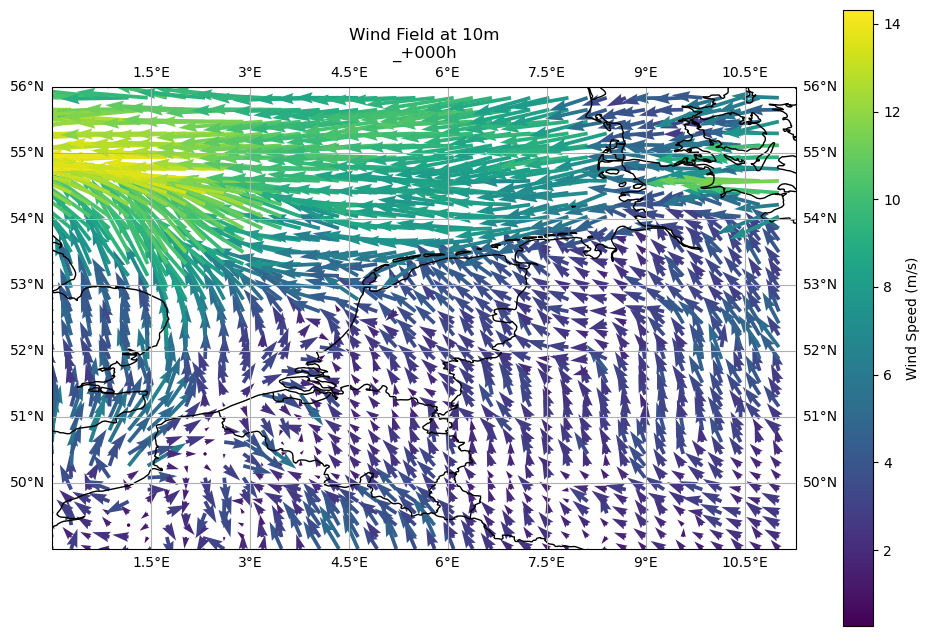

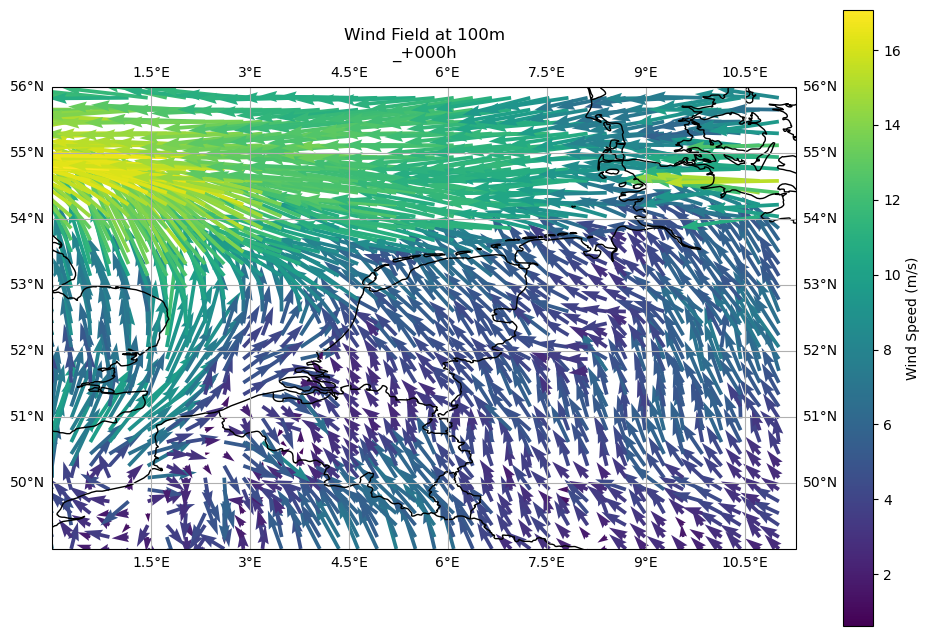

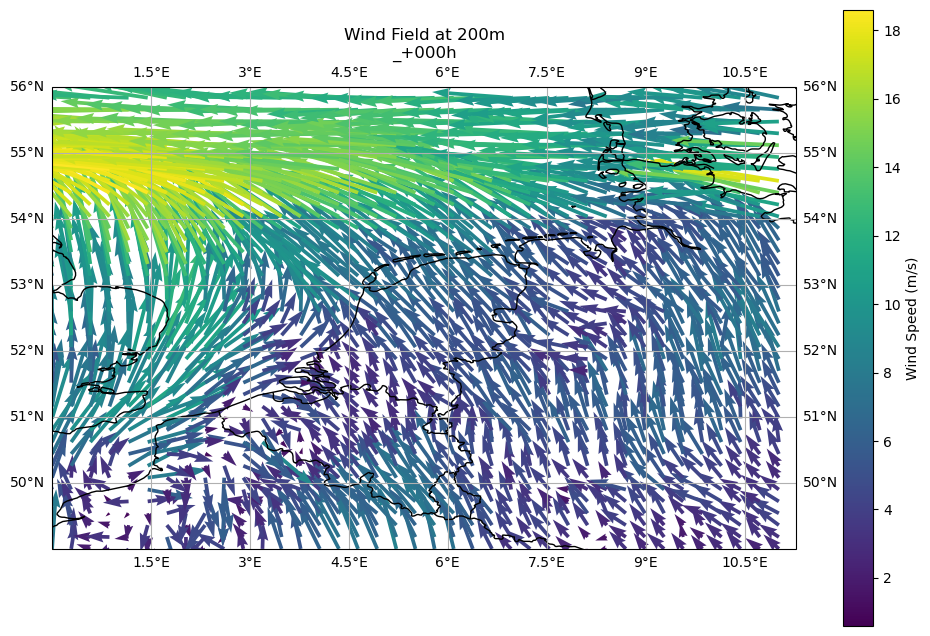

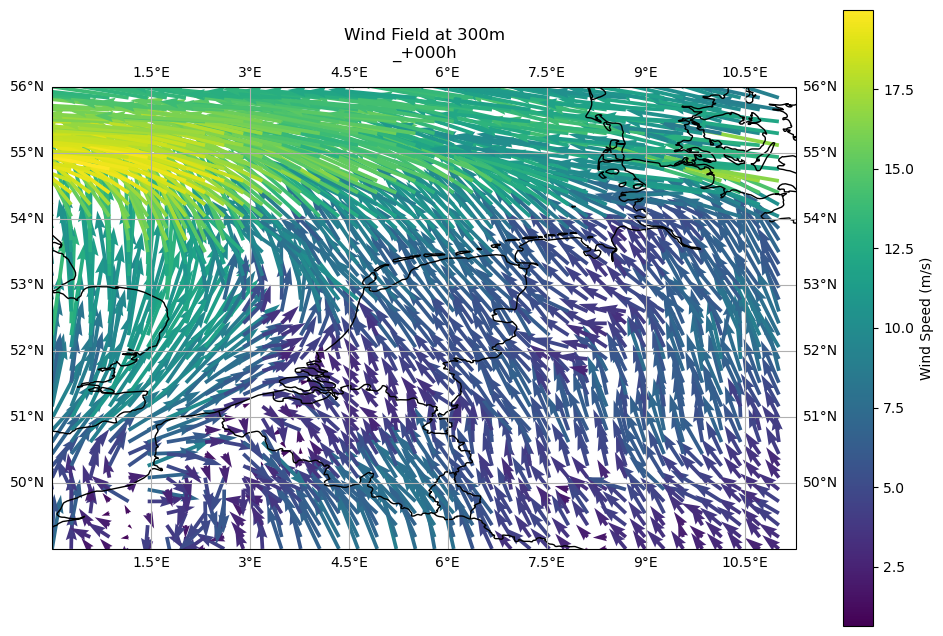

In [27]:
# Process a single file
input_file = "HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+000GB_UWCW01_N20e_selected.grb"
process_wind_fields(input_file)



In [ ]:
# Or process all files in a directory
def process_all_wind_fields():
    """Process wind fields for all time steps"""
    input_dir = "HARMONIE_AROME_meteo_24hrs/extracted_merged"
    for file in sorted(os.listdir(input_dir)):
        if file.endswith("_selected.grb"):
            input_file = os.path.join(input_dir, file)
            process_wind_fields(input_file)

# Process all files
process_all_wind_fields()

### one example for rainfall visualization

In [16]:
# 注意input_file的文件名，需要和提取的文件名一致
input_file = "HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+007GB_UWCW01_N20e_selected.grb"
print(f"\nReading data from: {input_file}")
data = ParameterMapper.read_grib_file(input_file)


Reading data from: HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+007GB_UWCW01_N20e_selected.grb

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 100 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 100 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of win

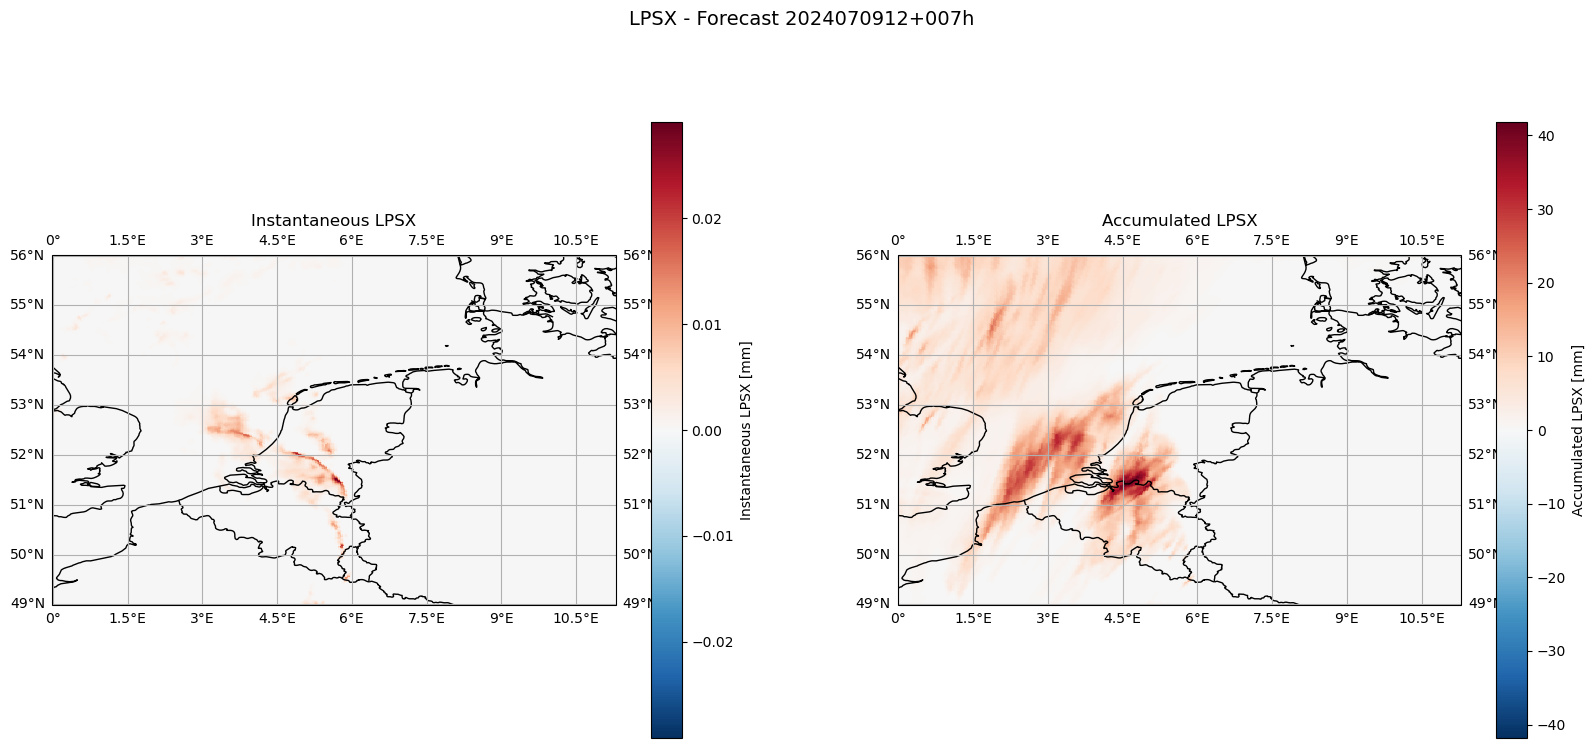

In [17]:
try:
    lpsx_instant = next(d for d in data 
                       if d['parameter']['shortName'] == 'LPSX' 
                       and d.get('timeRange', {}).get('indicator') == 0)
    lpsx_accum = next(d for d in data 
                     if d['parameter']['shortName'] == 'LPSX' 
                     and d.get('timeRange', {}).get('indicator') == 4)
     # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), 
                                  subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Common features for both plots
    for ax in (ax1, ax2):
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)
        ax.gridlines(draw_labels=True)
    
    # Plot 1: Instantaneous LPSX
    im1 = ax1.pcolormesh(
        lpsx_instant['data']['lons'],
        lpsx_instant['data']['lats'],
        lpsx_instant['data']['values'],
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmin=-np.max(abs(lpsx_instant['data']['values'])),
        vmax=np.max(abs(lpsx_instant['data']['values']))
    )
    plt.colorbar(im1, ax=ax1, 
                label=f"Instantaneous LPSX [{lpsx_instant['parameter']['units']}]")
    ax1.set_title("Instantaneous LPSX")
    
    # Plot 2: Accumulated LPSX
    im2 = ax2.pcolormesh(
        lpsx_accum['data']['lons'],
        lpsx_accum['data']['lats'],
        lpsx_accum['data']['values'],
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmin=-np.max(abs(lpsx_accum['data']['values'])),
        vmax=np.max(abs(lpsx_accum['data']['values']))
    )
    plt.colorbar(im2, ax=ax2, 
                label=f"Accumulated LPSX [{lpsx_accum['parameter']['units']}]")
    ax2.set_title("Accumulated LPSX")
    
    # Add timestamp to the main title
    plt.suptitle("LPSX - Forecast 2024070912+007h", y=1.02, fontsize=14)

    #  # Save plot
    # output_file = "extracted_data/pressure_gradient_plot.png"
    # print(f"\nCreating plot: {output_file}")
    # plt.savefig(output_file, dpi=300, bbox_inches='tight')
    # plt.close()
    
    # print("Plot created successfully!")
except StopIteration:
    print("\nError: Could not find LPSX parameters in the data!")
    print("Available parameters:")
    for d in data:
        print(f"- {d['parameter']['shortName']} ({d['parameter']['name']})")
except Exception as e:
    print(f"\nError: {e}")

### 计算两个步长间LPSX的差值，用于指代某小时内降雨量


Reading files:
Time 1 (+006h): HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+006GB_UWCW01_N20e_selected.grb
Time 2 (+007h): HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+007GB_UWCW01_N20e_selected.grb

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 100 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 100 (unknown)
  Time Range: instant

Grid

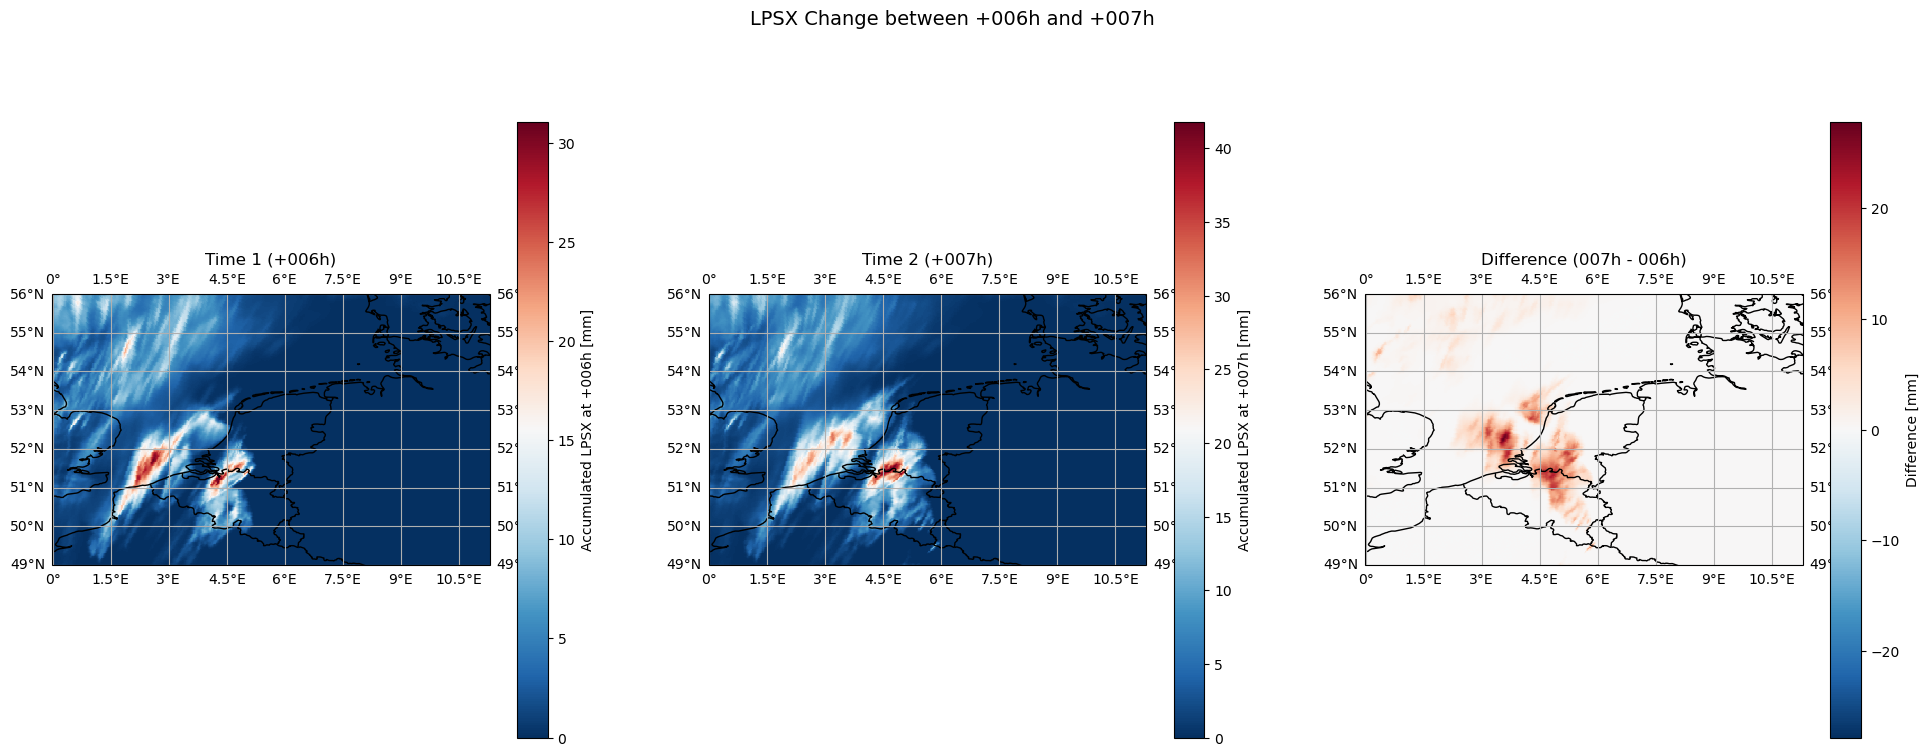

In [18]:
# 先一个例子1小时内的降雨量 （三张图，图1：+006h，图2：+007h，图3：+007h - +006h）
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

def calculate_hourly_difference(time1: str, time2: str, parameter: str = 'LPSX'):
    """
    Calculate difference between two timesteps
    计算两个时间步长之间的差值
    
    Args:
        time1: First timestep (earlier time)
        time2: Second timestep (later time)
        parameter: Parameter to analyze
    """
    # Read both files
    file1 = f"HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+{time1}GB_UWCW01_N20e_selected.grb"
    file2 = f"HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+{time2}GB_UWCW01_N20e_selected.grb"
    
    print(f"\nReading files:")
    print(f"Time 1 (+{time1}h): {file1}")
    print(f"Time 2 (+{time2}h): {file2}")
    
    # Read data from both files
    data1 = ParameterMapper.read_grib_file(file1)
    data2 = ParameterMapper.read_grib_file(file2)
    
    try:
        # Get accumulated LPSX for both times
        lpsx1 = next(d for d in data1 
                    if d['parameter']['shortName'] == parameter 
                    and d.get('timeRange', {}).get('indicator') == 4)
        lpsx2 = next(d for d in data2 
                    if d['parameter']['shortName'] == parameter 
                    and d.get('timeRange', {}).get('indicator') == 4)
        
        # Calculate difference
        diff_values = lpsx2['data']['values'] - lpsx1['data']['values']
        
        # Create visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8),
                                           subplot_kw={'projection': ccrs.PlateCarree()})
        
        # Common features for all plots
        for ax in (ax1, ax2, ax3):
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)
            ax.gridlines(draw_labels=True)
        
        # # Plot 1: First timestep
        im1 = ax1.pcolormesh(
            lpsx1['data']['lons'],
            lpsx1['data']['lats'],
            lpsx1['data']['values'],
            transform=ccrs.PlateCarree(),
            cmap='RdBu_r'
        )
        plt.colorbar(im1, ax=ax1, 
                    label=f"Accumulated {parameter} at +{time1}h [{lpsx1['parameter']['units']}]")
        ax1.set_title(f"Time 1 (+{time1}h)")
        
        # Plot 2: Second timestep
        im2 = ax2.pcolormesh(
            lpsx2['data']['lons'],
            lpsx2['data']['lats'],
            lpsx2['data']['values'],
            transform=ccrs.PlateCarree(),
            cmap='RdBu_r'
        )
        plt.colorbar(im2, ax=ax2, 
                    label=f"Accumulated {parameter} at +{time2}h [{lpsx2['parameter']['units']}]")
        ax2.set_title(f"Time 2 (+{time2}h)")
        
        # Plot 3: Difference
        im3 = ax3.pcolormesh(
            lpsx1['data']['lons'],
            lpsx1['data']['lats'],
            diff_values,
            transform=ccrs.PlateCarree(),
            cmap='RdBu_r',
            vmin=-np.max(abs(diff_values)),
            vmax=np.max(abs(diff_values))
        )
        plt.colorbar(im3, ax=ax3, 
                    label=f"Difference [{lpsx1['parameter']['units']}]")
        ax3.set_title(f"Difference ({time2}h - {time1}h)")
        
        # Add main title
        plt.suptitle(f"{parameter} Change between +{time1}h and +{time2}h", 
                    y=1.02, fontsize=14)
        
        # # Save plot
        # output_dir = "extracted_data/difference_analysis"
        # os.makedirs(output_dir, exist_ok=True)
        # output_file = f"{output_dir}/{parameter}_diff_{time1}h_{time2}h.png"
        # plt.savefig(output_file, dpi=300, bbox_inches='tight')
        # plt.close()
        
        # print(f"\nCreated difference analysis plot: {output_file}")
        
        # Return the difference data for further analysis if needed
        return {
            'parameter': parameter,
            'time1': time1,
            'time2': time2,
            'difference': diff_values,
            'coordinates': {
                'lons': lpsx1['data']['lons'],
                'lats': lpsx1['data']['lats']
            },
            'units': lpsx1['parameter']['units']
        }
        
    except StopIteration:
        print(f"\nError: Could not find {parameter} parameter in the data!")
        print("\nAvailable parameters in time 1:")
        for d in data1:
            print(f"- {d['parameter']['shortName']} ({d['parameter']['name']})")
        print("\nAvailable parameters in time 2:")
        for d in data2:
            print(f"- {d['parameter']['shortName']} ({d['parameter']['name']})")

# Calculate difference between +006h and +007h
diff_data = calculate_hourly_difference('006', '007', 'LPSX')

if diff_data:
    print("\nDifference statistics:")
    print(f"Min difference: {np.min(diff_data['difference'])} {diff_data['units']}")
    print(f"Max difference: {np.max(diff_data['difference'])} {diff_data['units']}")
    print(f"Mean difference: {np.mean(diff_data['difference'])} {diff_data['units']}")


Calculating difference between +006h and +007h

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 100 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 100 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 200 (u

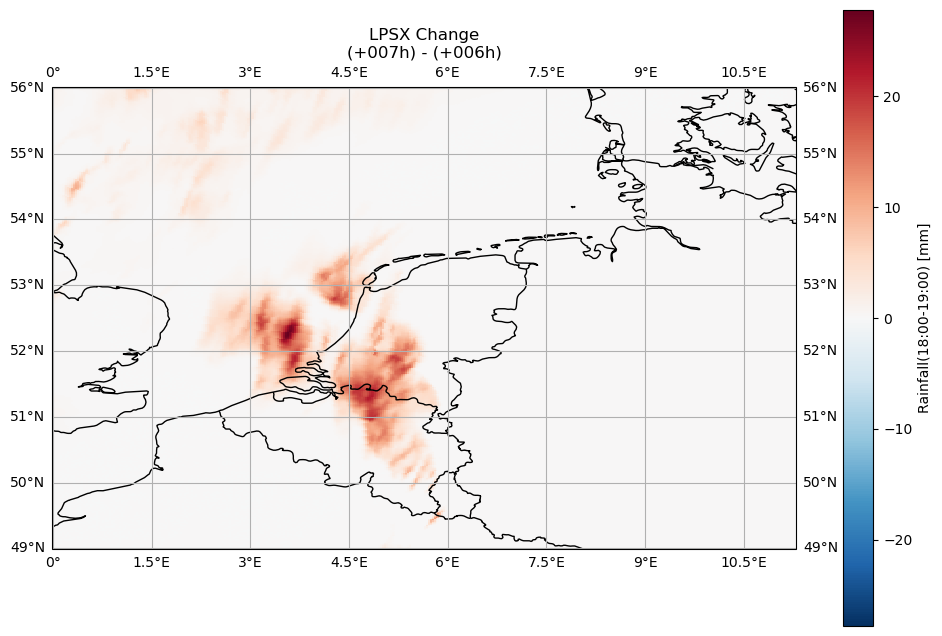

In [19]:
# 一张图，只展示上一步骤中的图3，即差值图
def plot_time_difference(time1: str, time2: str, parameter: str = 'LPSX'):
    """
    Plot the difference between two timesteps
    绘制两个时间步长之间的差值图
    """

    # Read both files
    file1 = f"HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+{time1}GB_UWCW01_N20e_selected.grb"
    file2 = f"HARMONIE_AROME_meteo_24hrs/extracted_merged/fc2024070912+{time2}GB_UWCW01_N20e_selected.grb"
    
    print(f"\nCalculating difference between +{time1}h and +{time2}h")
    
    # Read data from both files
    data1 = ParameterMapper.read_grib_file(file1)
    data2 = ParameterMapper.read_grib_file(file2)
    
    try:
        # Get accumulated values for both times
        param1 = next(d for d in data1 
                     if d['parameter']['shortName'] == parameter 
                     and d.get('timeRange', {}).get('indicator') == 4)
        param2 = next(d for d in data2 
                     if d['parameter']['shortName'] == parameter 
                     and d.get('timeRange', {}).get('indicator') == 4)
        
        # Calculate difference
        diff_values = param2['data']['values'] - param1['data']['values']
        
        # Create figure
        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=ccrs.PlateCarree())
        
        # Add map features
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS)
        ax.gridlines(draw_labels=True)
        
        # Plot difference
        im = ax.pcolormesh(
            param1['data']['lons'],
            param1['data']['lats'],
            diff_values,
            transform=ccrs.PlateCarree(),
            cmap='RdBu_r',
            vmin=-np.max(abs(diff_values)),  # Symmetric color scale
            vmax=np.max(abs(diff_values))
        )
        
        # Add colorbar
        plt.colorbar(im, label=f"Rainfall(18:00-19:00) [{param1['parameter']['units']}]")
        
        # Add title
        plt.title(f"{parameter} Change\n(+{time2}h) - (+{time1}h)")
        
        # # Save plot
        # output_dir = "extracted_data/difference_analysis"
        # os.makedirs(output_dir, exist_ok=True)
        # output_file = f"{output_dir}/{parameter}_diff_{time1}h_{time2}h.png"
        # plt.savefig(output_file, dpi=300, bbox_inches='tight')
        # plt.close()
        
        # print(f"Created difference plot: {output_file}")
        
    except StopIteration:
        print(f"\nError: Could not find {parameter} parameter in the data!")
        print("Available parameters:")
        for d in data1:
            print(f"- {d['parameter']['shortName']} ({d['parameter']['name']})")

# Calculate and plot difference between +006h and +007h
plot_time_difference('006', '007', 'LPSX')


Processing time period: 12:00 - 13:00

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: Rain
  Short Name: LPSX
  Code: 181
  Units: mm
  Level: 0 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: Rain
  Short Name: LPSX
  Code: 181
  Units: mm
  Level: 0 (unknown)
  Time Range: accumulated_total

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Gri

C:\Users\96454\AppData\Local\Temp\ipykernel_13064\3147033546.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12, 8))



Processing time period: 10:00 - 11:00

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: Rain
  Short Name: LPSX
  Code: 181
  Units: mm
  Level: 0 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: Rain
  Short Name: LPSX
  Code: 181
  Units: mm
  Level: 0 (unknown)
  Time Range: accumulated_total

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Gri

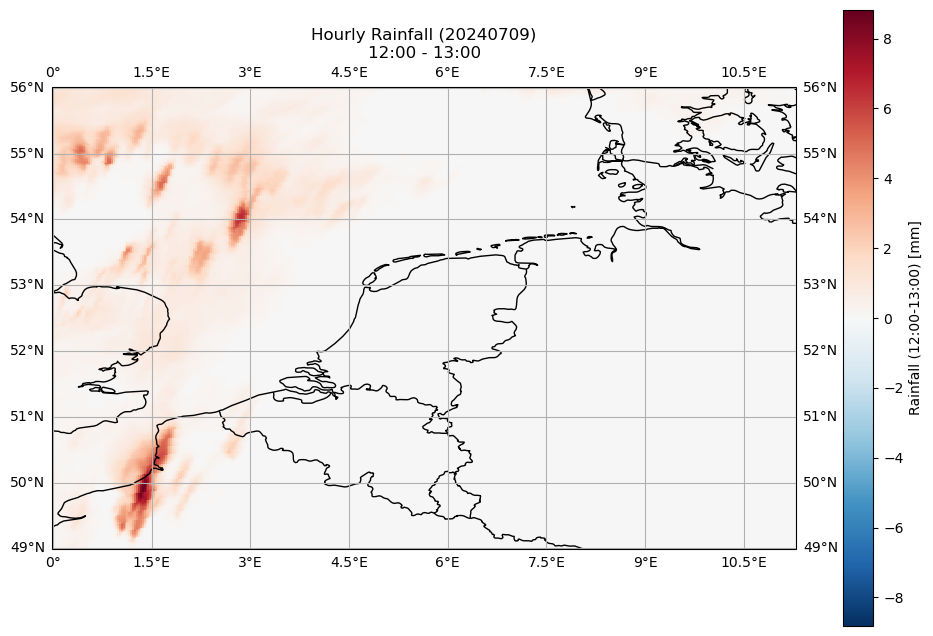

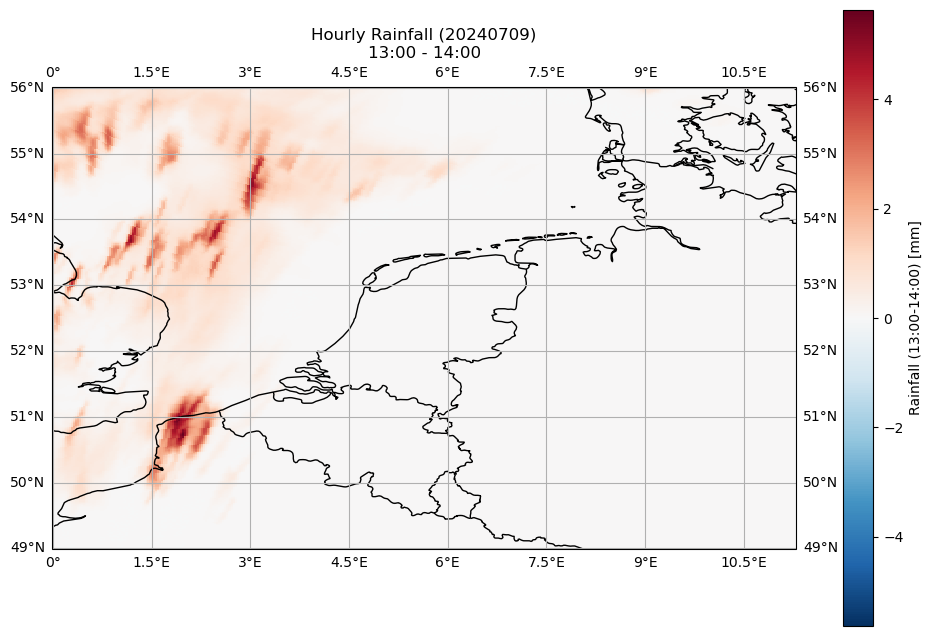

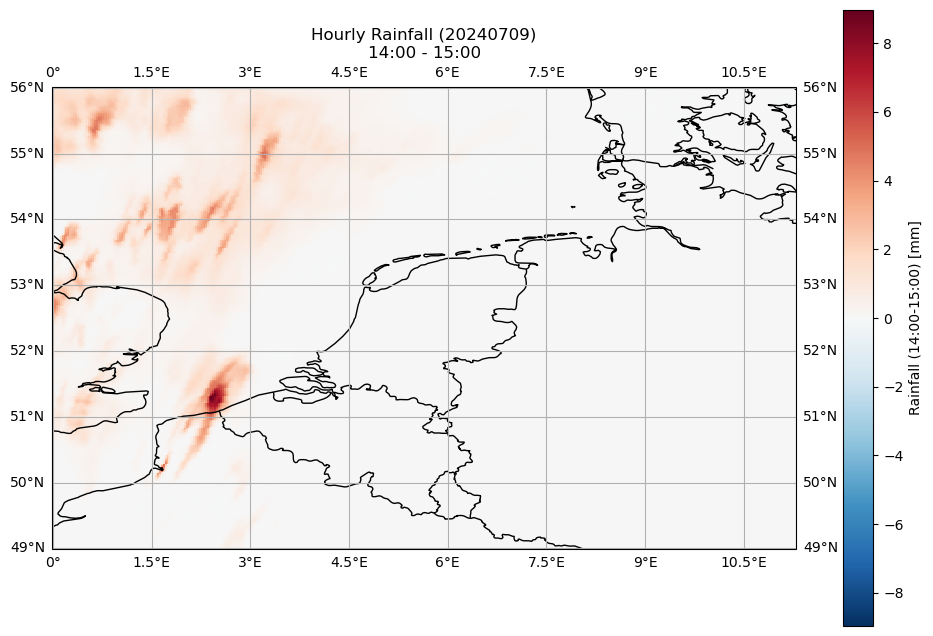

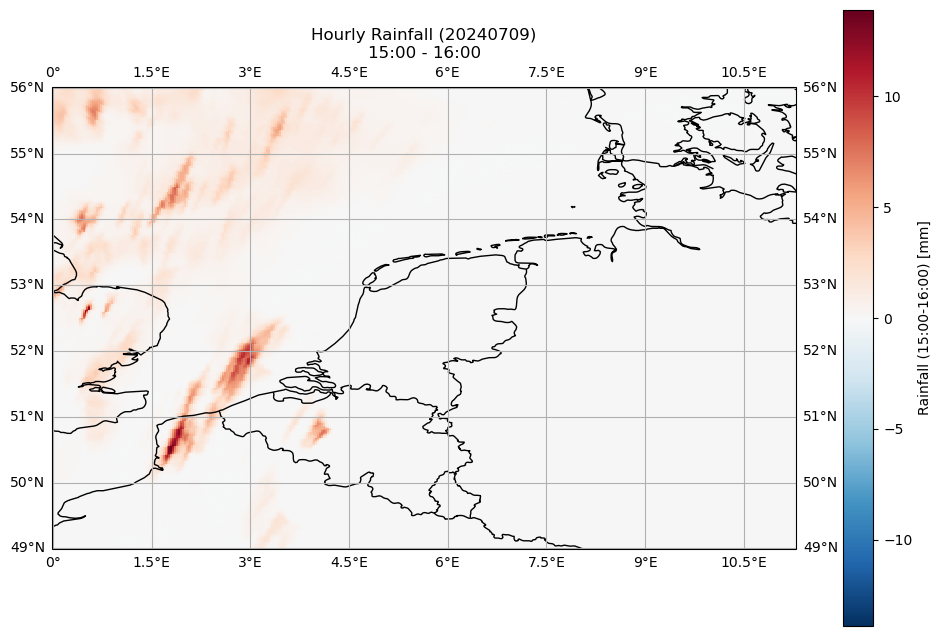

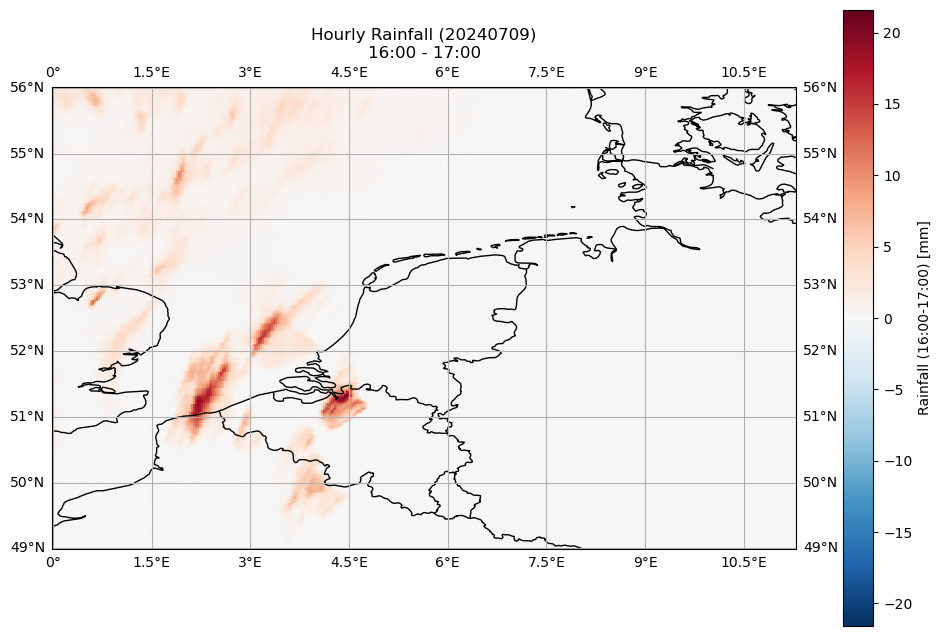

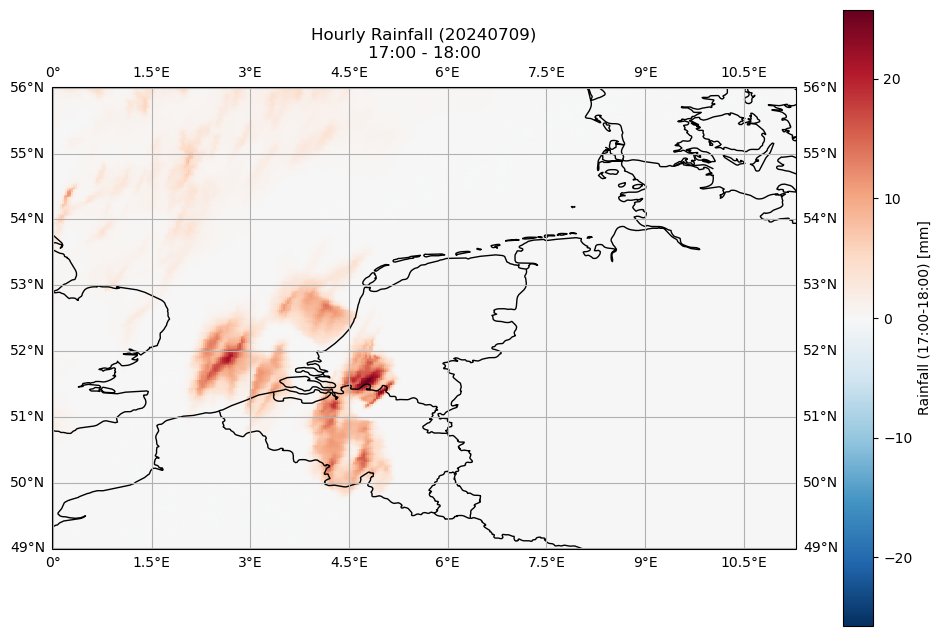

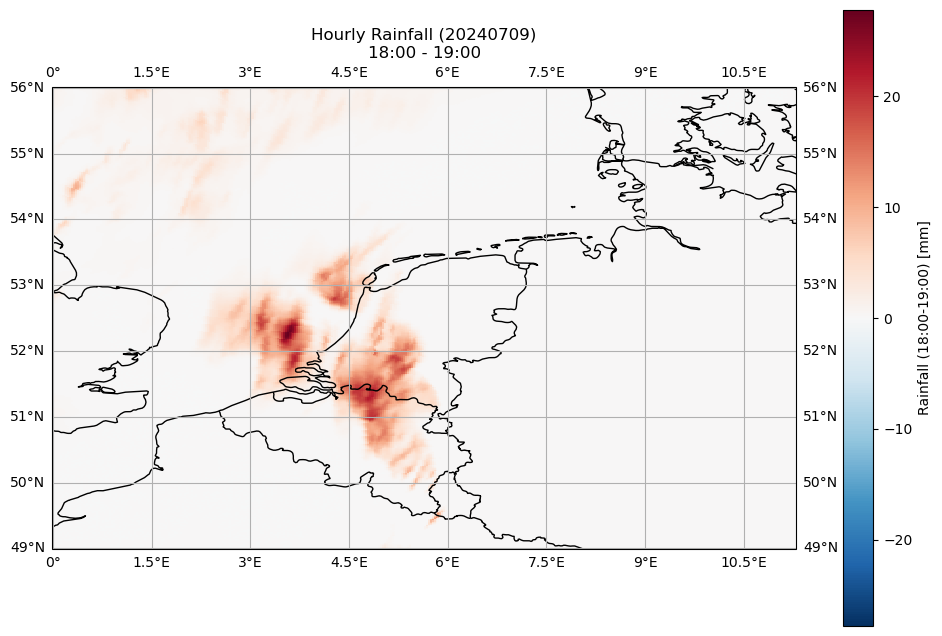

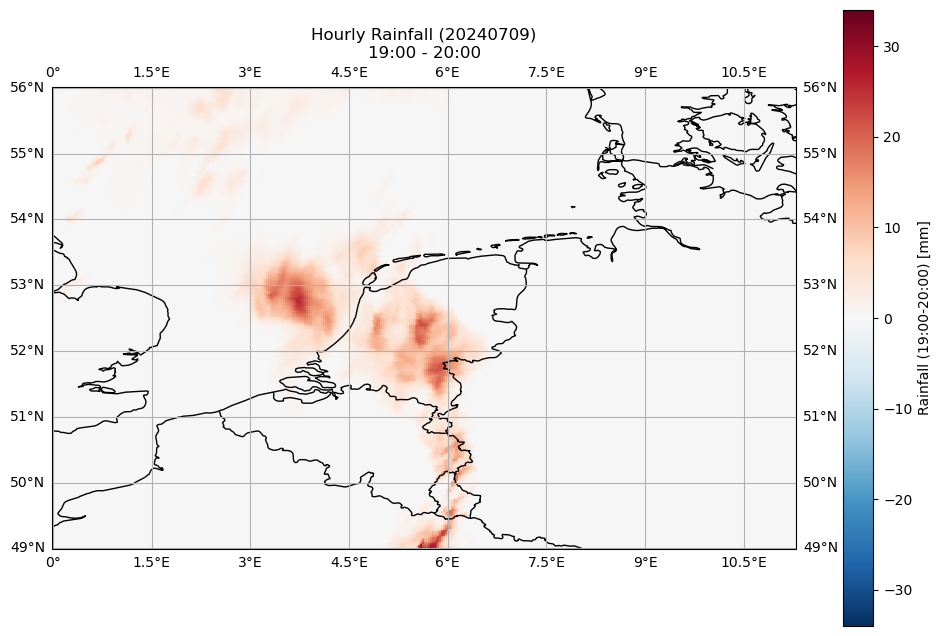

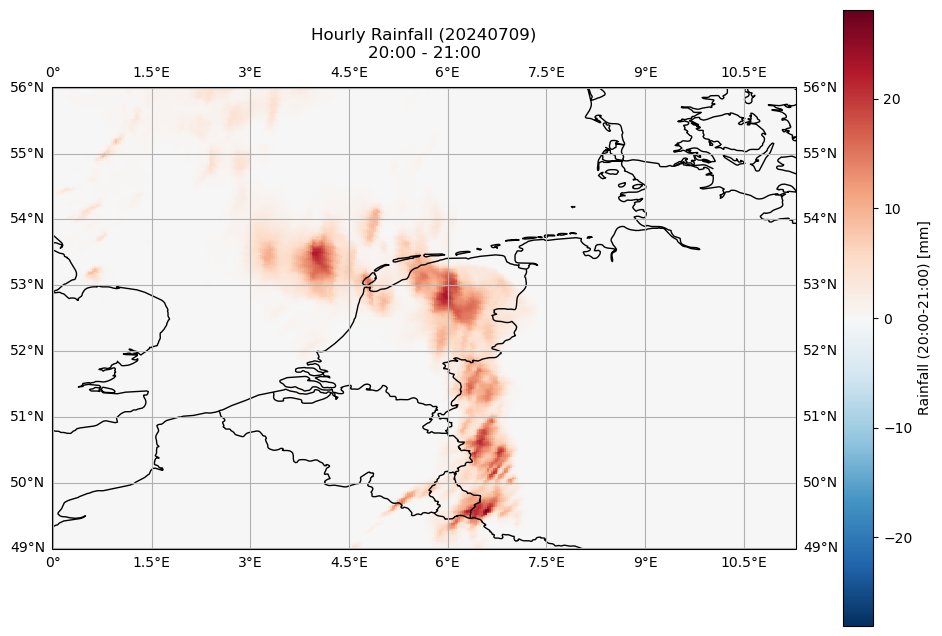

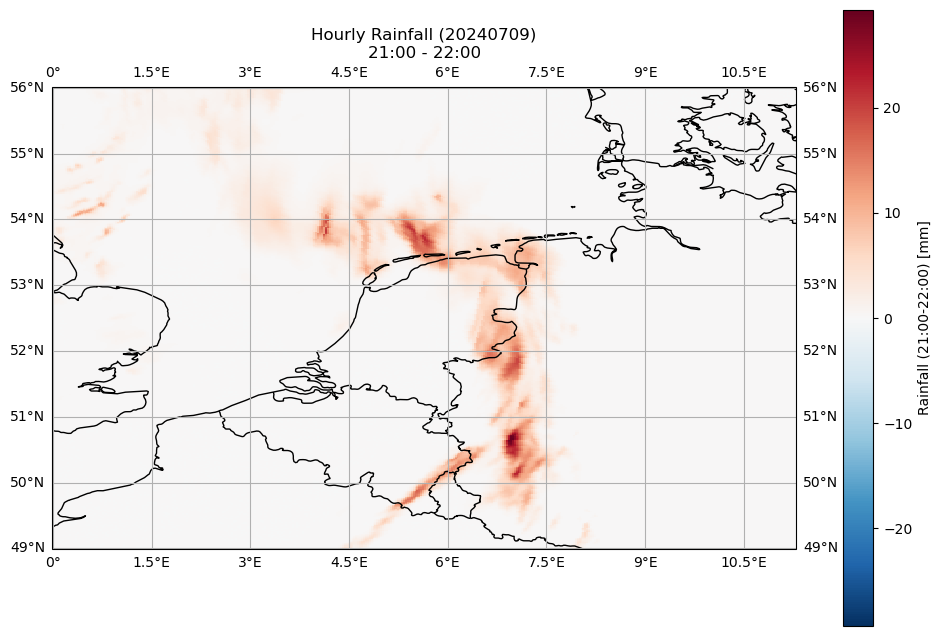

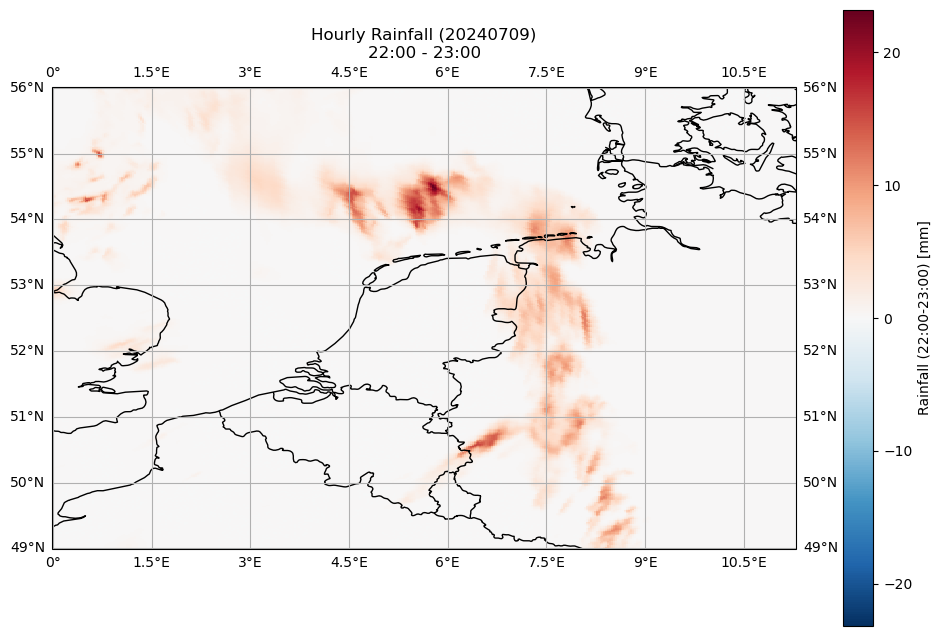

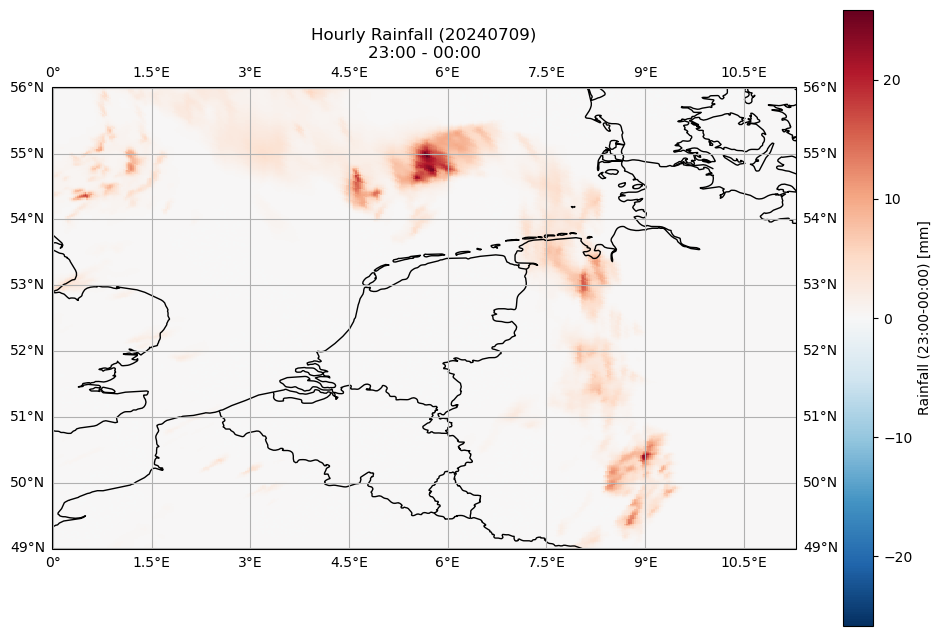

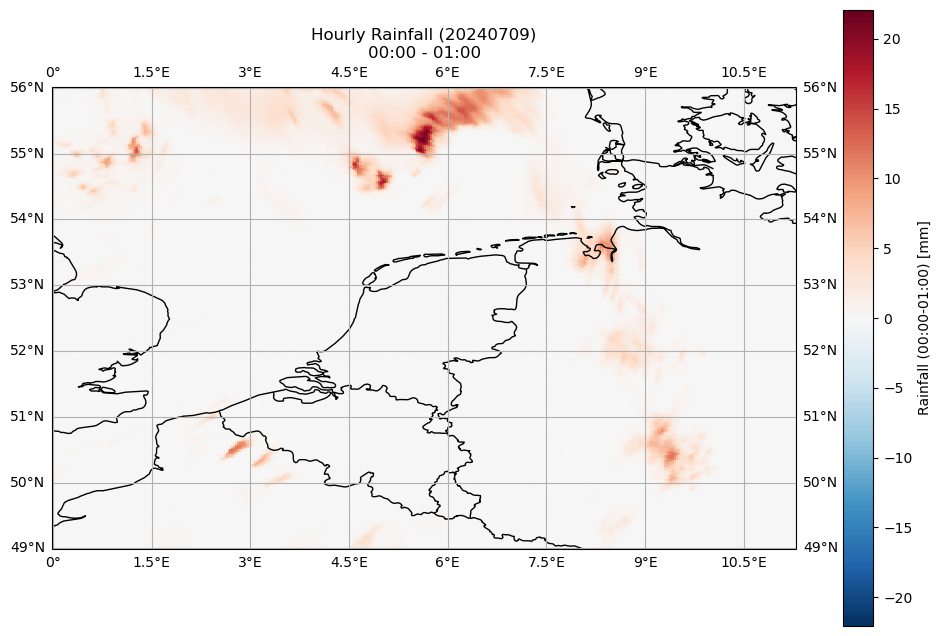

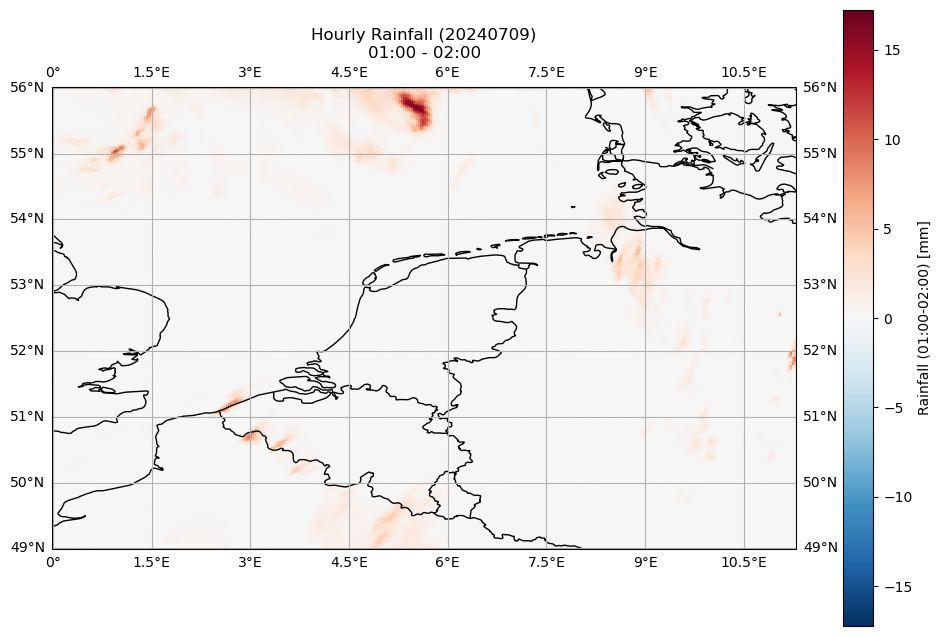

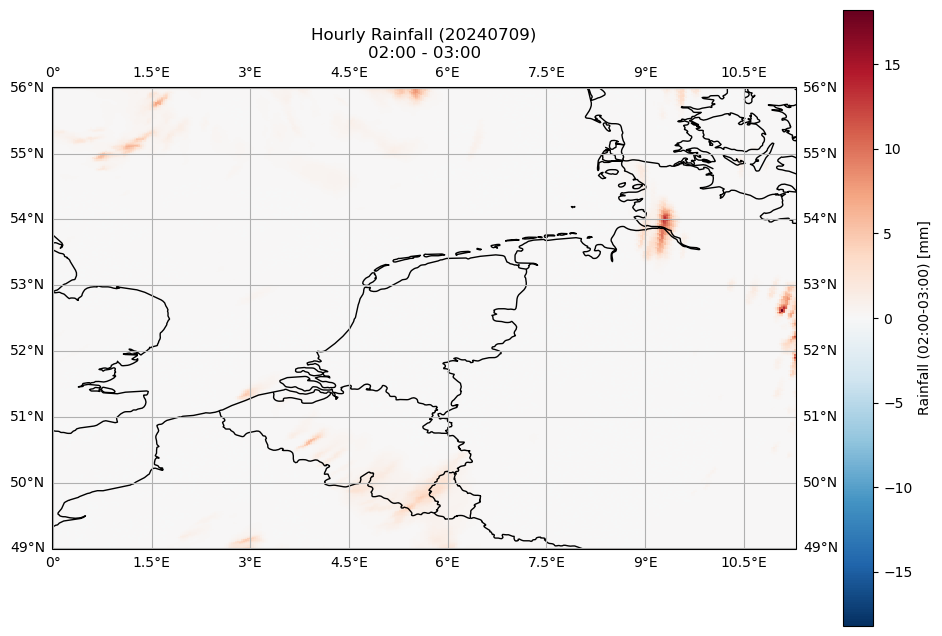

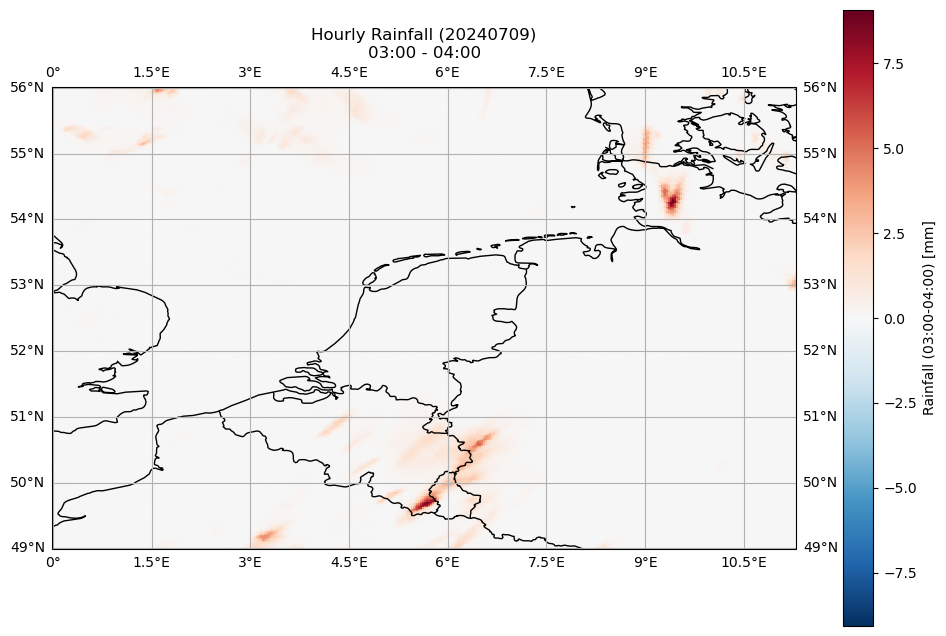

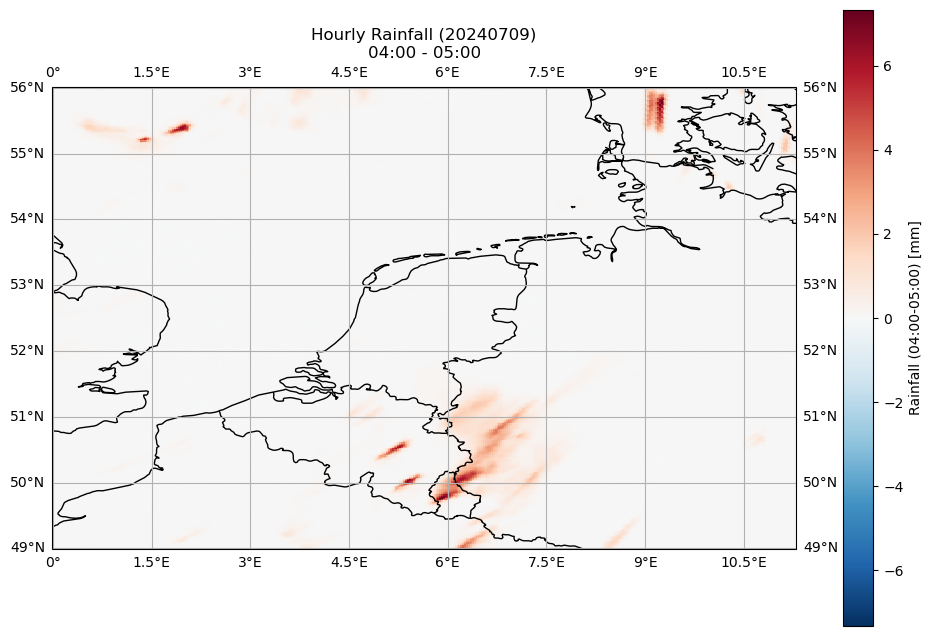

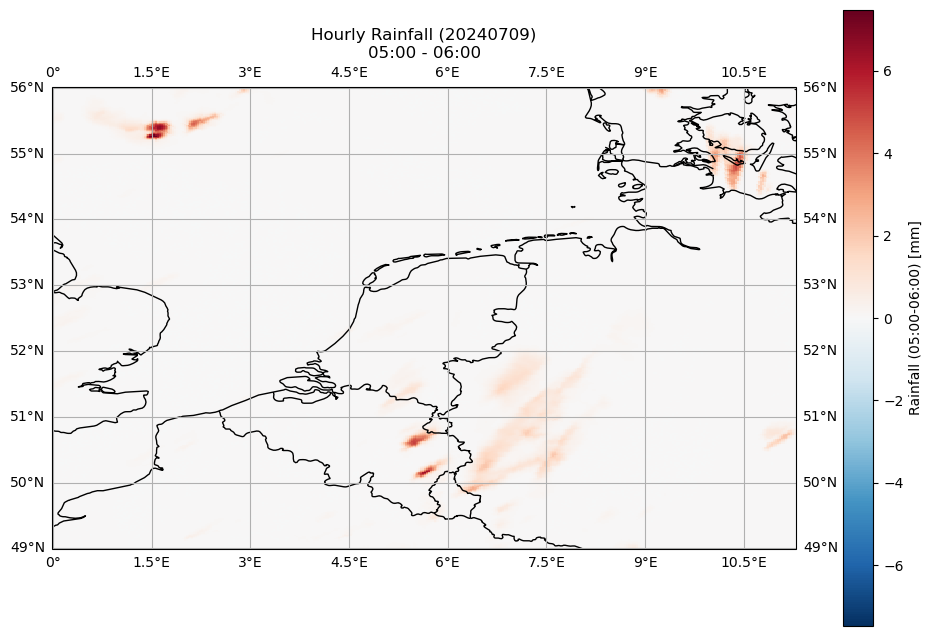

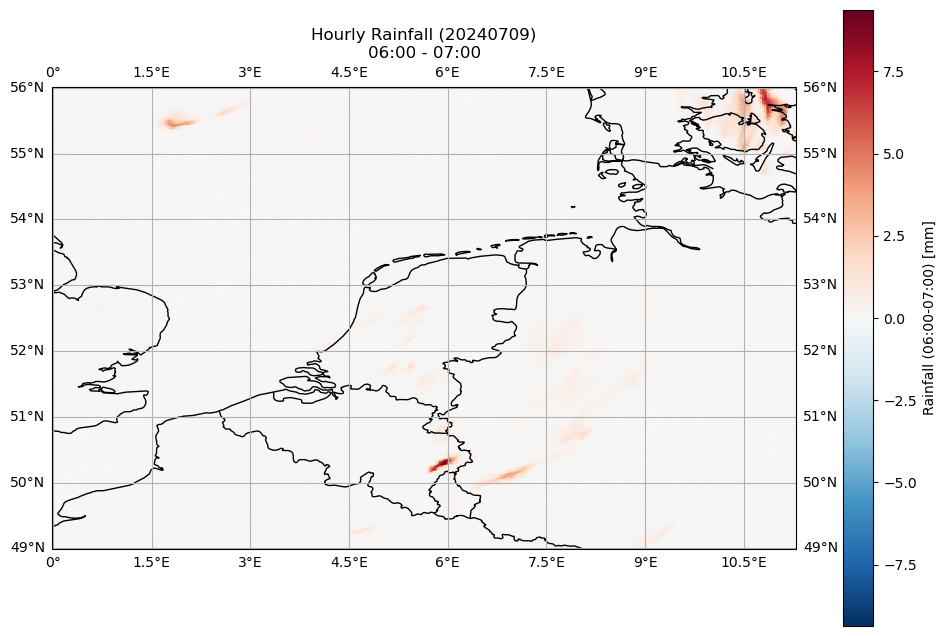

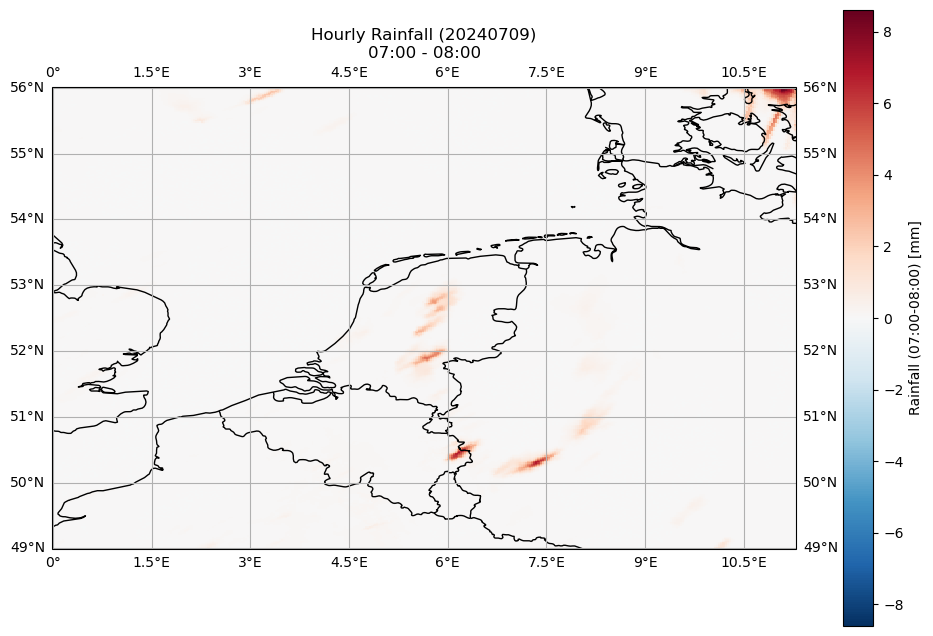

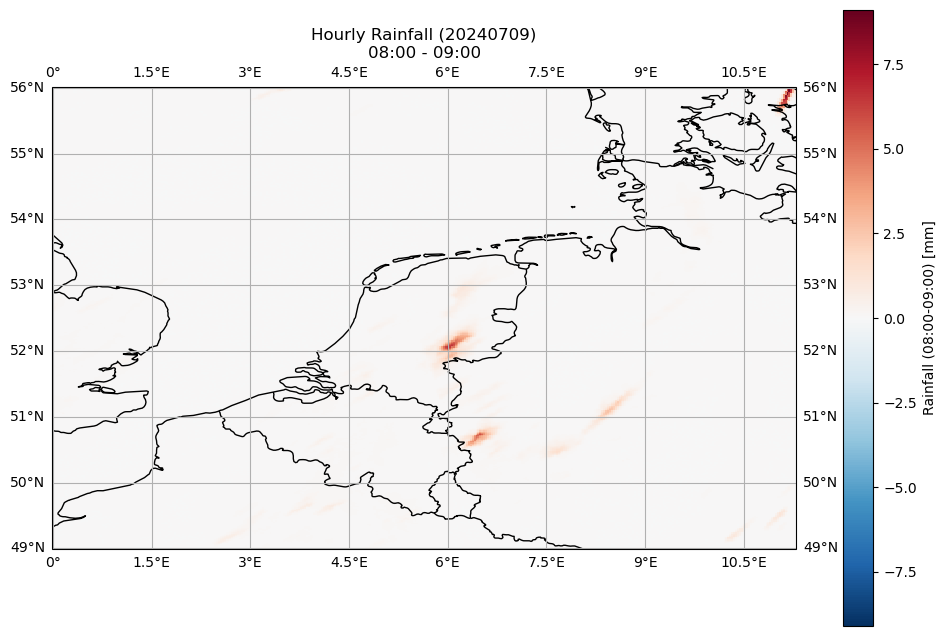

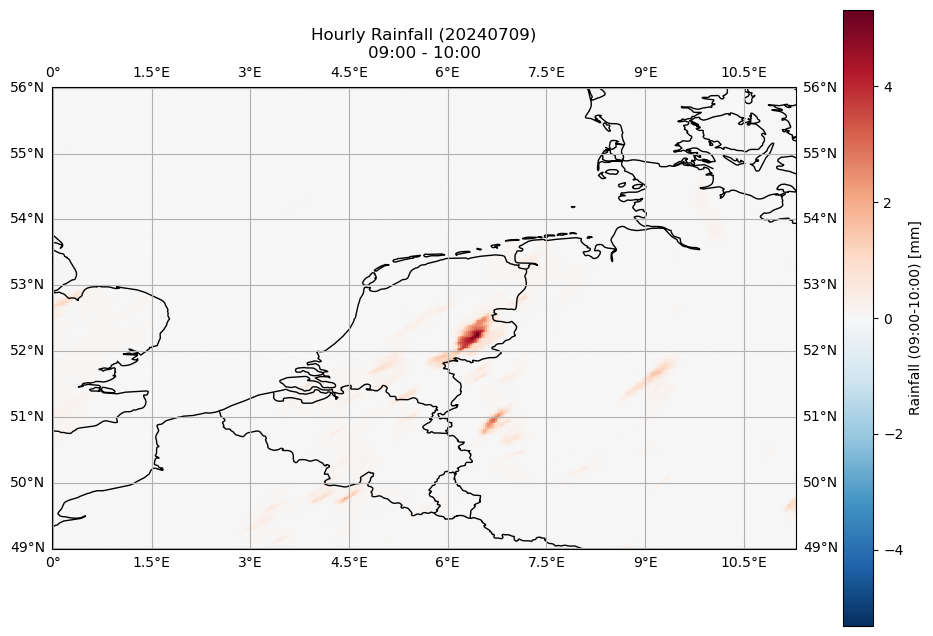

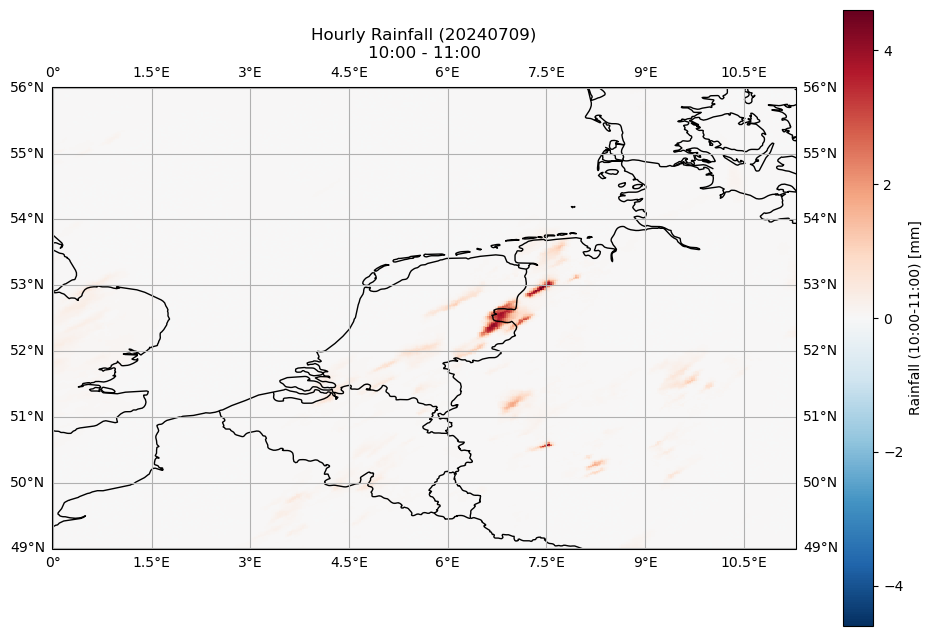

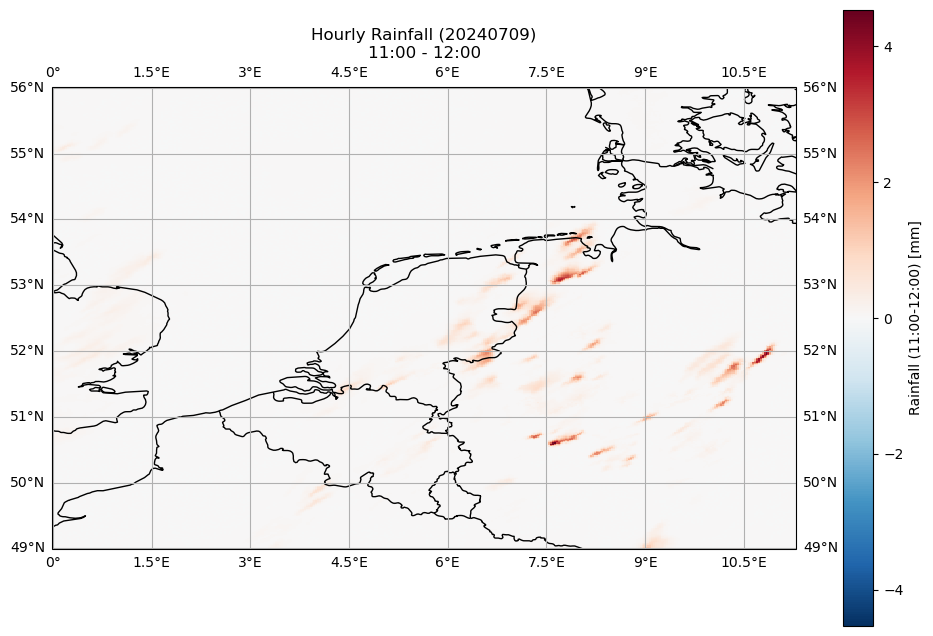

In [13]:
# 再对每隔文件进行循环，共计24个文件
def plot_24h_rainfall_differences(base_time: str = "2024070912", parameter: str = 'LPSX'):
    """
    Plot 24 hours of rainfall differences between consecutive timesteps
    绘制24小时内相邻时间步长的降水差值（从12:00开始）
    
    Args:
        base_time: Base time of forecast (YYYYMMDDHH format)
        parameter: Parameter to analyze (default: LPSX for rainfall)
    """
    base_path = "HARMONIE_AROME_meteo_24hrs/extracted_merged"
    output_path = f"{base_path}/rainfall_differences"
    os.makedirs(output_path, exist_ok=True)
    
    # Process 24 hours (from +000h to +024h)
    for hour in range(24):
        # Format current and next hour
        time1 = f"{hour:03d}"
        time2 = f"{hour+1:03d}"
        
        # Calculate actual time (starting from 12:00)
        actual_hour1 = (12 + hour) % 24
        actual_hour2 = (12 + hour + 1) % 24
        
        print(f"\nProcessing time period: {actual_hour1:02d}:00 - {actual_hour2:02d}:00")
        
        # Read both files
        file1 = f"{base_path}/fc{base_time}+{time1}GB_UWCW01_N20e_selected.grb"
        file2 = f"{base_path}/fc{base_time}+{time2}GB_UWCW01_N20e_selected.grb"
        
        try:
            # Read data from both files
            data1 = ParameterMapper.read_grib_file(file1)
            data2 = ParameterMapper.read_grib_file(file2)
            
            # Get accumulated values for both times
            param1 = next(d for d in data1 
                         if d['parameter']['shortName'] == parameter 
                         and d.get('timeRange', {}).get('indicator') == 4)
            param2 = next(d for d in data2 
                         if d['parameter']['shortName'] == parameter 
                         and d.get('timeRange', {}).get('indicator') == 4)
            
            # Calculate difference
            diff_values = param2['data']['values'] - param1['data']['values']
            
            # Create figure
            fig = plt.figure(figsize=(12, 8))
            ax = plt.axes(projection=ccrs.PlateCarree())
            
            # Add map features
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS)
            ax.gridlines(draw_labels=True)
            
            # Plot difference
            im = ax.pcolormesh(
                param1['data']['lons'],
                param1['data']['lats'],
                diff_values,
                transform=ccrs.PlateCarree(),
                cmap='RdBu_r',
                vmin=-np.max(abs(diff_values)),
                vmax=np.max(abs(diff_values))
            )
            
            # Format time strings with actual hours
            time1_str = f"{actual_hour1:02d}:00"
            time2_str = f"{actual_hour2:02d}:00"
            
            # Add colorbar
            plt.colorbar(im, label=f"Rainfall ({time1_str}-{time2_str}) [{param1['parameter']['units']}]")
            
            # Add title
            date_str = f"{base_time[:8]}"  # Extract YYYYMMDD
            plt.title(f"Hourly Rainfall ({date_str})\n{time1_str} - {time2_str}")
            
            ## Save plot with actual time in filename
            # output_file = f"{output_path}/rainfall_{actual_hour1:02d}00_{actual_hour2:02d}00.png"
            # plt.savefig(output_file, dpi=300, bbox_inches='tight')
            # plt.close()
            
            # print(f"Created rainfall difference plot: {output_file}")
            
        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
        except StopIteration:
            print(f"Error: Could not find {parameter} parameter in the data!")
            print("Available parameters:")
            for d in data1:
                print(f"- {d['parameter']['shortName']} ({d['parameter']['name']})")
        except Exception as e:
            print(f"Error processing time period {time1}h-{time2}h: {e}")

# Generate all 24 hourly rainfall difference plots
plot_24h_rainfall_differences()

## export selected files into other format in order to get them into unity

In [18]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

def convert_to_texture(data: dict, output_path: str, normalize: bool = True, 
                      format: str = 'PNG', bit_depth: int = 16):
    """
    Convert GRIB data to texture format for Unity
    将GRIB数据转换为Unity可用的纹理格式

    Args:
        data: Dictionary containing the parameter data
        output_path: Path to save the texture
        normalize: Whether to normalize the data to 0-1 range
        format: Output format ('PNG' or 'RAW')
        bit_depth: Bit depth for the output (8 or 16)
    """
    # Get the values array
    values = data['data']['values']
    
    if normalize:
        # Normalize to 0-1 range
        min_val = np.min(values)
        max_val = np.max(values)
        normalized = (values - min_val) / (max_val - min_val)
    else:
        normalized = values

    if format.upper() == 'PNG':
        # Convert to 8-bit or 16-bit grayscale
        if bit_depth == 8:
            # Scale to 0-255
            scaled = (normalized * 255).astype(np.uint8)
        else:
            # Scale to 0-65535
            scaled = (normalized * 65535).astype(np.uint16)
        
        # Create image
        img = Image.fromarray(scaled)
        
        # Save image
        img.save(output_path)
        
        # Save metadata (for reconstruction in Unity)
        metadata = {
            'original_min': float(min_val),
            'original_max': float(max_val),
            'parameter': data['parameter']['shortName'],
            'units': data['parameter']['units'],
            'dimensions': values.shape,
            'coordinates': {
                'lat_min': float(data['data']['lats'].min()),
                'lat_max': float(data['data']['lats'].max()),
                'lon_min': float(data['data']['lons'].min()),
                'lon_max': float(data['data']['lons'].max())
            }
        }
        
        # Save metadata as JSON
        import json
        metadata_path = os.path.splitext(output_path)[0] + '_metadata.json'
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
            
    elif format.upper() == 'RAW':
        # Save as raw binary file
        if bit_depth == 16:
            # Convert to 16-bit values
            scaled = (normalized * 65535).astype(np.uint16)
            scaled.tofile(output_path)
        else:
            # Convert to 8-bit values
            scaled = (normalized * 255).astype(np.uint8)
            scaled.tofile(output_path)
            
        # Save dimensions info
        dim_path = os.path.splitext(output_path)[0] + '_dimensions.txt'
        with open(dim_path, 'w') as f:
            f.write(f"Width: {values.shape[1]}\n")
            f.write(f"Height: {values.shape[0]}\n")
            f.write(f"Original Min: {min_val}\n")
            f.write(f"Original Max: {max_val}\n")



In [19]:
# 这里只转换了一个lpsx_instant的文件，如果需要转换其他文件，只需要修改对应的参数即可

def main():
    # Read the GRIB file
    input_file = "extracted_data/fc2024070912+001GB_UWCW01_N20e_selected.grb"
    print(f"\nReading data from: {input_file}")
    data = ParameterMapper.read_grib_file(input_file)
    
    # Create output directory
    os.makedirs("unity_textures", exist_ok=True)
    
    try:
        # Convert LPSX data
        lpsx_instant = next(d for d in data 
                          if d['parameter']['shortName'] == 'LPSX' 
                          and d.get('timeRange', {}).get('indicator') == 0)
        
        # Convert to PNG texture
        png_output = "unity_textures/lpsx_instant.png"
        convert_to_texture(lpsx_instant, png_output, format='PNG', bit_depth=16)
        print(f"Created PNG texture: {png_output}")
        
        # Convert to RAW texture
        raw_output = "unity_textures/lpsx_instant.raw"
        convert_to_texture(lpsx_instant, raw_output, format='RAW', bit_depth=16)
        print(f"Created RAW texture: {raw_output}")
        
        # Create preview visualization
        plt.figure(figsize=(10, 8))
        plt.imshow(lpsx_instant['data']['values'], cmap='RdBu_r')
        plt.colorbar(label=f"Pressure Gradient [{lpsx_instant['parameter']['units']}]")
        plt.title("Pressure Gradient Texture Preview")
        plt.savefig("unity_textures/lpsx_preview.png")
        plt.close()
        
    except StopIteration:
        print("\nError: Could not find LPSX parameter in the data!")
        print("Available parameters:")
        for d in data:
            print(f"- {d['parameter']['shortName']} ({d['parameter']['name']})")

if __name__ == "__main__":
    main()


Reading data from: extracted_data/fc2024070912+001GB_UWCW01_N20e_selected.grb

Parameter Information:
  Name: U-component of wind
  Short Name: UGRD
  Code: 33
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: V-component of wind
  Short Name: VGRD
  Code: 34
  Units: m/s
  Level: 10 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: x-gradient of log pressure
  Short Name: LPSX
  Code: 181
  Units: 1/m
  Level: 0 (unknown)
  Time Range: instant

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°

Parameter Information:
  Name: x-gradient of log pressure
  Short Name: LPSX
  Code: 181
  Units: 1/m
  Level: 0 (unknown)
  Time Range: accumulated_total

Grid Information:
  Dimensions: 390 x 390
  Resolution: 0.0° x 0.029°
Created PNG texture: unity_textures/lpsx_instant.png
Crea